# Loop Detection Tutorial

In [1]:
from loop_detection import loop_detection, Range, get_UC
from loop_detection.loop_detection_code import get_rule_set, get_aliases
from loop_detection.generation.gen import create_collection_rules, generate_fw_tables, print_from_fw_tables

Take the following fowarding tables

In [2]:
# each node has a base rule H but the actions for the base rule can differ

fw_tables = {i : [] for i in range(4)}

fw_tables[0] = [('R1', Range(1,5), 1), 
                ('R2', Range(1,4), 1), 
                ('R3', Range(0,1), None),
                ('H0', Range(0,5), None)]

fw_tables[1] =  [('R4', Range(2,4), 3), 
                 ('H1', Range(0,5), None)]

fw_tables[2] = [('R5', Range(0, 4), 3), 
                ('H2', Range(0,5), None)]

fw_tables[3] =  [('R6', Range(4, 5), None), 
                 ('R7', Range(2,3), 1),
                 ('H3', Range(0,5), None)]

fw_tables

{0: [('R1', [1, 5], 1),
  ('R2', [1, 4], 1),
  ('R3', [0, 1], None),
  ('H0', [0, 5], None)],
 1: [('R4', [2, 4], 3), ('H1', [0, 5], None)],
 2: [('R5', [0, 4], 3), ('H2', [0, 5], None)],
 3: [('R6', [4, 5], None), ('R7', [2, 3], 1), ('H3', [0, 5], None)]}

The keys of the dictionnary are the names of the nodes/routers of the network. Each node is associated with a list of rules, where each rule has a name, the set of headers it matches and an action. The action can be the name of another node in case of forwarding, or `None` in case of a drop.

Let's see how the networks looks like.

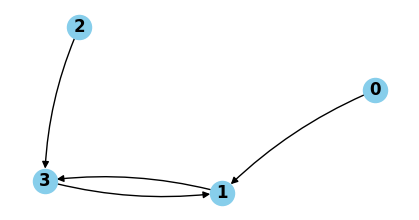

In [3]:
print_from_fw_tables(fw_tables)

The network is a directed graph where an edge between node A and node B means that there is a rule in node A whose action is to forward to node B.

Note that in our example, there is a loop between 1 and 3.

Let us collect all the rules found in our forwarding tables.

In [4]:
rule_set = get_rule_set(fw_tables)
rule_set

{'R1': (0, [1, 5], 1),
 'R2': (0, [1, 4], 1),
 'R3': (0, [0, 1], None),
 'H0': (0, [0, 5], None),
 'R4': (1, [2, 4], 3),
 'H1': (1, [0, 5], None),
 'R5': (2, [0, 4], 3),
 'H2': (2, [0, 5], None),
 'R7': (3, [2, 3], 1),
 'R6': (3, [4, 5], None),
 'H3': (3, [0, 5], None)}

Note that H0, H1, H2, H3 are different names for the same rule (at different locations). 

`get_aliases`gives all the possible names for a given rule.

In [6]:
aliases = get_aliases(rule_set)
aliases

{[1, 5]: {'R1'},
 [1, 4]: {'R2'},
 [0, 1]: {'R3'},
 [0, 5]: {'H0', 'H1', 'H2', 'H3'},
 [2, 4]: {'R4'},
 [0, 4]: {'R5'},
 [2, 3]: {'R7'},
 [4, 5]: {'R6'}}

Let us remove redundant copies of the same rule. This will speed up the equivalence class computation.

In [7]:
R = [(key, values[1]) for key, values in rule_set.items()]
unique_count = {key: 0 for key in aliases.keys()}
R_set = set()
for rule in R:
    if unique_count[rule[1]] == 0:
        R_set.add(rule)
        unique_count[rule[1]] += 1
R_set

{('H0', [0, 5]),
 ('R1', [1, 5]),
 ('R2', [1, 4]),
 ('R3', [0, 1]),
 ('R4', [2, 4]),
 ('R5', [0, 4]),
 ('R6', [4, 5]),
 ('R7', [2, 3])}

Let us get the uncovered combinations generated by these rules.

In [8]:
UC = get_UC(R_set)
print(len(UC), 'atoms :')
for uc in UC:
    print(uc.get_name(),', value =', uc)

5 atoms :
H0 & R5 & R3 , value = [0, 1]
H0 & R1 & R5 & R4 & R6 , value = [4, 4]
H0 & R1 & R5 & R3 , value = [1, 1]
H0 & R1 & R5 & R4 & R7 , value = [2, 3]
H0 & R1 & R6 , value = [4, 5]


Now, let us run the loop verification.

In [9]:
result = loop_detection(fw_tables)
result

[([2, 3], [[1, 3]])]

The output is a list of tuples, where the first element is the combination of rules creating loops, and the second element is a list of cycles associated to the combination.

Let us parse the output to have a more readable result.

In [10]:
if len(result) > 0:
    print('Found a loop')
    for res in result:
        print('Loop followed by:',  res[0].get_name(), ', value =', res[0])
        nodes_involved = set()
        for edge in res[1]:
            nodes_involved.add(edge[0])
            nodes_involved.add(edge[1])
        print('Nodes involved:', nodes_involved)

Found a loop
Loop followed by: H0 & R1 & R5 & R4 & R7 , value = [2, 3]
Nodes involved: {1, 3}


Now, let's test on a random network.

------------------------------------------------------------
Fowarding table:

Node 0
('H0', [0, 10], None)
('R00', [9, 10], 3)

Node 1
('H1', [0, 10], 2)
('R01', [8, 9], None)
('R11', [2, 6], 4)

Node 2
('H2', [0, 10], 0)
('R02', [4, 8], None)
('R12', [1, 6], 4)

Node 3
('H3', [0, 10], 2)
('R03', [6, 7], 2)
('R13', [6, 9], 4)
('R23', [1, 3], 0)

Node 4
('H4', [0, 10], None)
('R04', [2, 4], None)

------------------------------------------------------------
Graph of the whole network


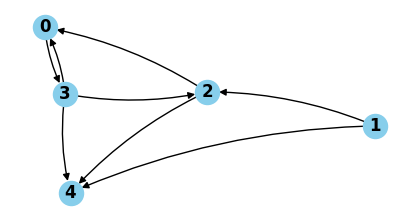

------------------------------------------------------------
1 loops detected

Details:

Atom: H0 & R13 & R00 , value = [9, 9]
1 loops
Nodes involved:
Cycle 1 : [0, 3, 2]



In [15]:
gen_fw_tables = generate_fw_tables(5, max_range = 10)
print('-'*60)
print('Fowarding table:')
print()
for key, value in gen_fw_tables.items():
    print('Node', key)
    for rule in value:
        print(rule)
    print()
print('-'*60)
print("Graph of the whole network")
print_from_fw_tables(gen_fw_tables)
result = loop_detection(gen_fw_tables)
print('-'*60)
nb_loops = sum(len(res[1]) for res in result)
print(nb_loops, 'loops detected')
print()
print('Details:')
print()
for res in result:
    print('Atom:',  res[0].get_name(), ', value =', res[0])
    print(len(res[1]), 'loops')
    print('Nodes involved:')
    for i, cycle in enumerate(res[1]):
        print('Cycle', i + 1 , ':', cycle)
    print()

A second random example:

------------------------------------------------------------
Fowarding table:

Node 0
('H0', [0, 10], None)
('R00', [5, 6], None)

Node 1
('H1', [0, 10], 3)
('R01', [4, 6], 3)
('R11', [4, 8], 0)

Node 2
('H2', [0, 10], None)
('R02', [0, 4], 0)
('R12', [0, 8], 4)

Node 3
('H3', [0, 10], None)
('R03', [3, 4], 1)
('R13', [5, 6], 1)
('R23', [3, 4], 1)

Node 4
('H4', [0, 10], None)
('R04', [3, 7], 3)
('R14', [1, 3], 2)

------------------------------------------------------------
Graph of the whole network


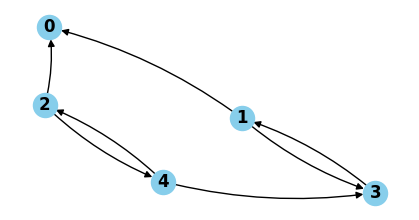

------------------------------------------------------------
5 loops detected

Details:

Atom: H0 & R12 & R02 & R04 & R11 , value = [4, 4]
1 loops
Nodes involved:
Cycle 1 : [1, 3]

Atom: H0 & R12 & R02 & R04 & R14 , value = [3, 3]
2 loops
Nodes involved:
Cycle 1 : [2, 4]
Cycle 2 : [1, 3]

Atom: H0 & R12 & R04 & R11 & R01 & R00 , value = [5, 6]
1 loops
Nodes involved:
Cycle 1 : [1, 3]

Atom: H0 & R12 & R02 & R14 , value = [1, 3]
1 loops
Nodes involved:
Cycle 1 : [2, 4]



In [17]:
gen_fw_tables = generate_fw_tables(5, max_range = 10)
print('-'*60)
print('Fowarding table:')
print()
for key, value in gen_fw_tables.items():
    print('Node', key)
    for rule in value:
        print(rule)
    print()
print('-'*60)
print("Graph of the whole network")
print_from_fw_tables(gen_fw_tables)
result = loop_detection(gen_fw_tables)
print('-'*60)
nb_loops = sum(len(res[1]) for res in result)
print(nb_loops, 'loops detected')
print()
print('Details:')
print()
for res in result:
    print('Atom:',  res[0].get_name(), ', value =', res[0])
    print(len(res[1]), 'loops')
    print('Nodes involved:')
    for i, cycle in enumerate(res[1]):
        print('Cycle', i + 1 , ':', cycle)
    print()